In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import time

In [2]:
# Set random seed untuk reproduktibilitas
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# 1. Memuat dan Memproses Data
data_df = pd.read_excel('residual_arima.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d-%m-%Y')
data_df.set_index('Date', inplace=True)
residuals = data_df['Residual'].values.astype(float)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(-1, 1))
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

In [4]:
# Differencing untuk membuat data lebih stasioner
def apply_differencing(data, order=1):
    diff = np.diff(data, n=order)
    return diff

# Normalisasi setelah differencing
residuals_diff = apply_differencing(residuals)
residuals_scaled = scaler.fit_transform(residuals_diff.reshape(-1, 1)).flatten()

In [5]:
# 2. Membuat Dataset Time Series
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Hyperparameter baru
TIME_STEP = 48  # Window size lebih besar
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.0001
D_MODEL = 128
NHEAD = 8
NUM_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.2

# Membuat dataset
X, y = create_dataset(residuals_scaled, TIME_STEP)

# Split data 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Konversi ke tensor PyTorch
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Shape: (samples, time_step, 1)
y_train = torch.FloatTensor(y_train).unsqueeze(-1)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_test = torch.FloatTensor(y_test).unsqueeze(-1)

In [6]:
# 3. Membuat DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# 4. Arsitektur Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 1. Definisikan PositionalEncoding terlebih dahulu
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# 2. Definisikan TimeSeriesTransformer
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, time_step):
        super(TimeSeriesTransformer, self).__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.time_step = time_step
        
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(d_model, 1)
        
    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        
        # Untuk time series forecasting, kita bisa menggunakan src sebagai memory dan tgt
        tgt = torch.zeros_like(src)  # Target awal bisa diinisialisasi dengan nol
        
        output = self.transformer(src, tgt)
        output = self.fc_out(output[:, -1, :])  # Ambil output terakhir
        return output

# 3. Sekarang baru definisikan parameter dan inisialisasi model
TIME_STEP = 24
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
D_MODEL = 64
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1

# Inisialisasi model
model = TimeSeriesTransformer(
    input_size=1,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    time_step=TIME_STEP
)

# 4. Lanjutkan dengan bagian lainnya
criterion = nn.MSELoss()

# Dalam loop training
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Early stopping
best_loss = float('inf')
patience = 20
counter = 0

# Cetak arsitektur model untuk verifikasi
print(model)

TimeSeriesTransformer(
  (embedding): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    

Epoch 1/100 - Loss: 1.167512 - Time: 1.09s
Epoch 2/100 - Loss: 0.293657 - Time: 0.94s
Epoch 3/100 - Loss: 0.120547 - Time: 0.96s
Epoch 4/100 - Loss: 0.130532 - Time: 1.06s
Epoch 5/100 - Loss: 0.086463 - Time: 0.99s
Epoch 6/100 - Loss: 0.095134 - Time: 0.94s
Epoch 7/100 - Loss: 0.075222 - Time: 0.92s
Epoch 8/100 - Loss: 0.079557 - Time: 1.11s
Epoch 9/100 - Loss: 0.075904 - Time: 0.92s
Epoch 10/100 - Loss: 0.076632 - Time: 0.89s
Epoch 11/100 - Loss: 0.073440 - Time: 0.88s
Epoch 12/100 - Loss: 0.077469 - Time: 0.86s
Epoch 13/100 - Loss: 0.073231 - Time: 0.89s
Epoch 14/100 - Loss: 0.069316 - Time: 0.91s
Epoch 15/100 - Loss: 0.072072 - Time: 1.02s
Epoch 16/100 - Loss: 0.072544 - Time: 0.91s
Epoch 17/100 - Loss: 0.070934 - Time: 0.92s
Epoch 18/100 - Loss: 0.069649 - Time: 0.98s
Epoch 19/100 - Loss: 0.070839 - Time: 1.02s
Epoch 20/100 - Loss: 0.070853 - Time: 1.03s
Epoch 21/100 - Loss: 0.070384 - Time: 0.91s
Epoch 22/100 - Loss: 0.069545 - Time: 0.94s
Epoch 23/100 - Loss: 0.072550 - Time: 0.9

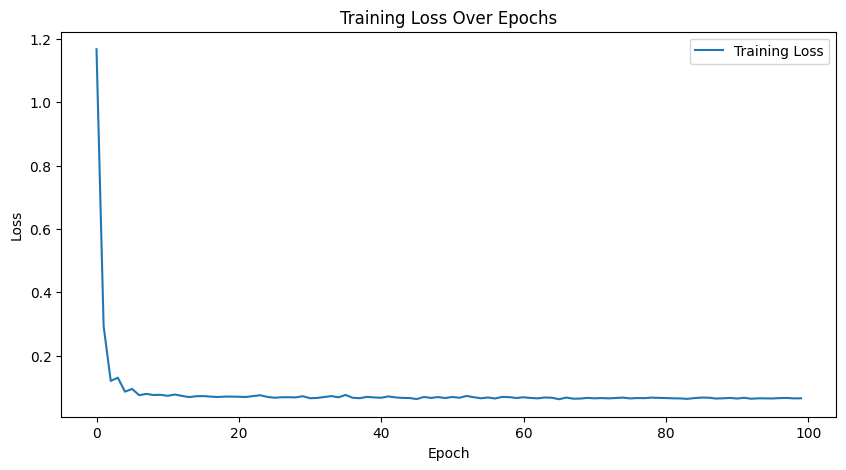

In [8]:
# 5. Pelatihan Model
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    train_loss = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)
        
        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f} - Time: {elapsed_time:.2f}s')
    
    return train_loss

# Jalankan pelatihan
train_loss = train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Plot loss training
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Training dan evaluasi di sini

def calculate_r_squared(actual, predicted):
    """Menghitung R-squared score"""
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# Modifikasi fungsi evaluate_model untuk menyertakan R-squared
def evaluate_model(model, test_loader, criterion, scaler):
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            predictions.extend(output.numpy())
            actuals.extend(target.numpy())
    
    # Denormalize data
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    
    avg_loss = test_loss / len(test_loader)
    mse = mean_squared_error(actuals, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = calculate_r_squared(actuals, predictions)
    
    print(f'Test Loss: {avg_loss:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R-squared: {r2:.6f}')
    
    return predictions, actuals

# Jalankan evaluasi dengan R-squared
predictions, actuals = evaluate_model(model, test_loader, criterion, scaler)

Test Loss: 0.071060
MSE: 4066.928467
RMSE: 63.772474
MAE: 37.900608
R-squared: -0.004020


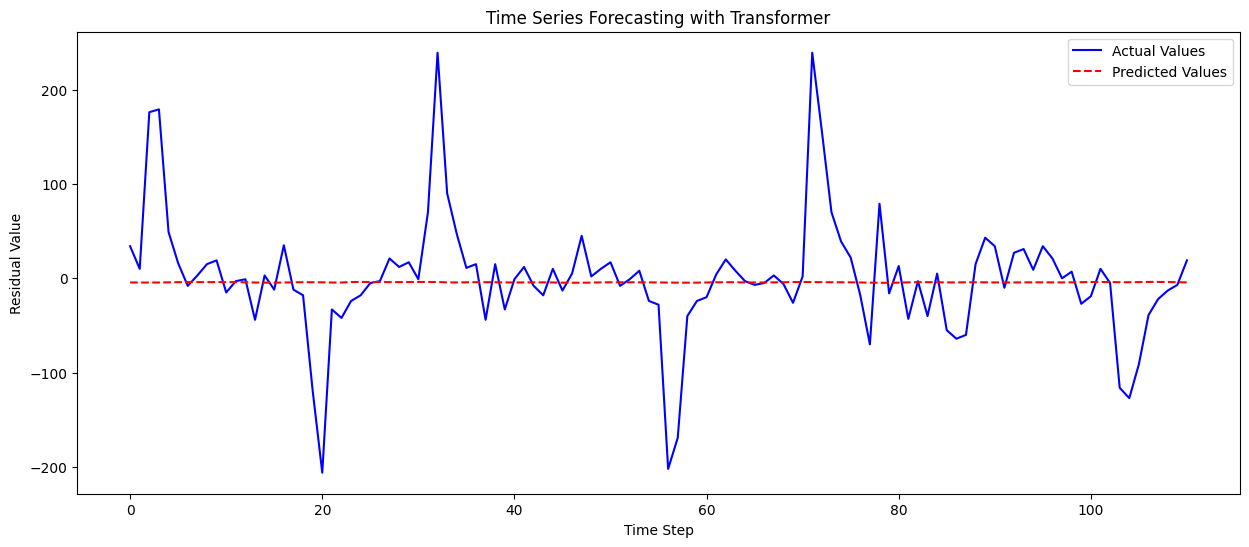

In [10]:
# 7. Visualisasi Hasil
plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')
plt.title('Time Series Forecasting with Transformer')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

In [11]:
# 8. Simpan Model
torch.save(model.state_dict(), 'transformer_time_series.pth')

# Untuk memuat model:
# model = TimeSeriesTransformer(input_size=1, d_model=D_MODEL, nhead=NHEAD, 
#                              num_encoder_layers=NUM_ENCODER_LAYERS, 
#                              num_decoder_layers=NUM_DECODER_LAYERS,
#                              dim_feedforward=DIM_FEEDFORWARD, 
#                              dropout=DROPOUT, time_step=TIME_STEP)
# model.load_state_dict(torch.load('transformer_time_series.pth'))